In [1]:
import gc
import glob
import os
import matplotlib.pyplot as plt
import time

import numpy as np
import pandas as pd
import pyarrow
import pyarrow.feather as pf
import pyarrow.parquet as pq

from collections import Counter, OrderedDict
from recsys.utils import group_lengths, reduce_mem_usage, timer

%matplotlib inline

In [2]:
pd.options.display.max_rows = 128
pd.options.display.max_columns = 128

plt.rcParams['figure.figsize'] = (14, 10)
plt.style.use('ggplot')

In [3]:
def get_submission_target(df):
    """Identify target rows with missing click outs."""

    mask = df["reference"].isnull() & (df["action_type"] == "clickout item")
    df_out = df[mask]

    return df_out

In [4]:
LOAD_TEST = True
DEBUG = False
REMOVE_ORIG = False
N_ROWS = int(1e5)


with timer('reading data...'):
    train = pf.read_feather('../data/train.feather')
    print('train shape: {}'.format(train.shape))
    train['is_test'] = int(False)
    if LOAD_TEST:
        test = pf.read_feather('../data/test.feather')
        print('test shape: {}'.format(test.shape))
        test["is_test"] = (
            test["reference"].isnull() & (test["action_type"] == "clickout item")).astype(np.int)
        df_all = pd.concat([train, test], ignore_index=True, sort=False)
    else:
        df_all = train

    if DEBUG:
        print('debug mode, use {} rows.'.format(N_ROWS))
        df_all = df_all.iloc[:N_ROWS, :].reset_index(drop=True)
    if REMOVE_ORIG:
        print('remove orig train and test')
        del train, test
        gc.collect()
    
    item_metadata = pf.read_feather('../data/item_metadata.feather')
    
    df_all = reduce_mem_usage(df_all)
    test = get_submission_target(df_all)
    train = df_all.loc[~df_all.index.isin(test.index), :]
    assert train.shape[0] + test.shape[0] == df_all.shape[0]

train shape: (15932992, 12)
test shape: (3782335, 12)
Mem. usage decreased to 1729.78 Mb (11.5% reduction)
[reading data...] done in 23 s


### reference:

In [5]:
# Doesn't make much sense for real train/test split

# train references
train_refs = train.reference.unique()
train_refs = pd.to_numeric(train_refs, errors='coerce')
train_refs = train_refs[np.isfinite(train_refs)].astype(int)
# test references
test_refs = test.reference.unique()
test_refs = pd.to_numeric(test_refs, errors='coerce')
test_refs = test_refs[np.isfinite(test_refs)].astype(int)

print('number of train refs: {}'.format(len(set(train_refs))))
print('number of test refs: {}'.format(len(set(test_refs))))

train_ref_intersect = len(set(item_metadata.item_id).intersection(train_refs))
test_ref_intersect = len(set(item_metadata.item_id).intersection(test_refs))

print('number of train refs intersection: {}'.format(train_ref_intersect))
print('number of test refs intersection: {}'.format(test_ref_intersect))

number of train refs: 394238
number of test refs: 0
number of train refs intersection: 393884
number of test refs intersection: 0


### impressions:

In [6]:
train_impressions = train.impressions[~pd.isna(train.impressions)]
train_impressions = np.concatenate(train_impressions.apply(lambda x: x.split('|')).values).astype(int)
train_impressions_counter = Counter(train_impressions)

test_impressions = test.impressions[~pd.isna(test.impressions)]
test_impressions = np.concatenate(test_impressions.apply(lambda x: x.split('|')).values).astype(int)
test_impressions_counter = Counter(test_impressions)

In [7]:
train_impr_unique = np.unique(train_impressions)
test_impr_unique = np.unique(test_impressions)

impr_intersect = set(train_impr_unique).intersection(set(test_impr_unique))
impr_diff = set(train_impr_unique).difference(set(test_impr_unique))

print('fraction of impressions intersection: {:.3f}'.format(len(impr_intersect) / len(train_impr_unique)))
print('fraction of impressions difference: {:.3f}'.format(len(impr_diff) / len(train_impr_unique)))

fraction of impressions intersection: 0.626
fraction of impressions difference: 0.374


### user_id:

In [8]:
train_user_unique = train.user_id.unique()
test_user_unique = test.user_id.unique()

user_intersect = set(train_user_unique).intersection(set(test_user_unique))
user_diff = set(train_user_unique).difference(set(test_user_unique))

print('fraction of user_id intersection: {:.3f}'.format(len(user_intersect) / len(train_user_unique)))
print('fraction of user_id difference: {:.3f}'.format(len(user_diff) / len(train_user_unique)))

fraction of user_id intersection: 0.222
fraction of user_id difference: 0.778


### session_id:

In [9]:
train_session_unique = train.session_id.unique()
test_session_unique = test.session_id.unique()

session_intersect = set(train_session_unique).intersection(set(test_session_unique))
session_diff = set(train_session_unique).difference(set(test_session_unique))

print('fraction of session_id intersection: {:.3f}'.format(len(session_intersect) / len(train_session_unique)))
print('fraction of session_id difference: {:.3f}'.format(len(session_diff) / len(train_session_unique)))

fraction of session_id intersection: 0.169
fraction of session_id difference: 0.831


In [10]:
session_len = train[['session_id', 'user_id']].groupby(
    ['session_id']).count().rename(columns={'user_id': 'session_len'})
test_session_len = test[['session_id', 'user_id']].groupby(
    ['session_id']).count().rename(columns={'user_id': 'session_len'})

# Look at sessions in train and test set:
session_len = session_len.join(test_session_len, how='outer', rsuffix='_test')
session_len_nonna = session_len.dropna()
# Subset long sessions:
session_len_long = session_len_nonna.loc[session_len_nonna.session_len > 10, :]
print(len(session_len_nonna), len(session_len_long))

session_len_long

192971 58390


,session_len,session_len_test
session_id,,
000246890bfc6,32.0,1.0
00035287b3cd6,21.0,1.0
0003ce539baa5,15.0,1.0
0004913471800,23.0,1.0
000737a92bc59,42.0,1.0
0008cd59f6797,13.0,1.0
000b098df63ce,17.0,1.0
000b7d3346b45,41.0,1.0
000bb397ca596,53.0,1.0


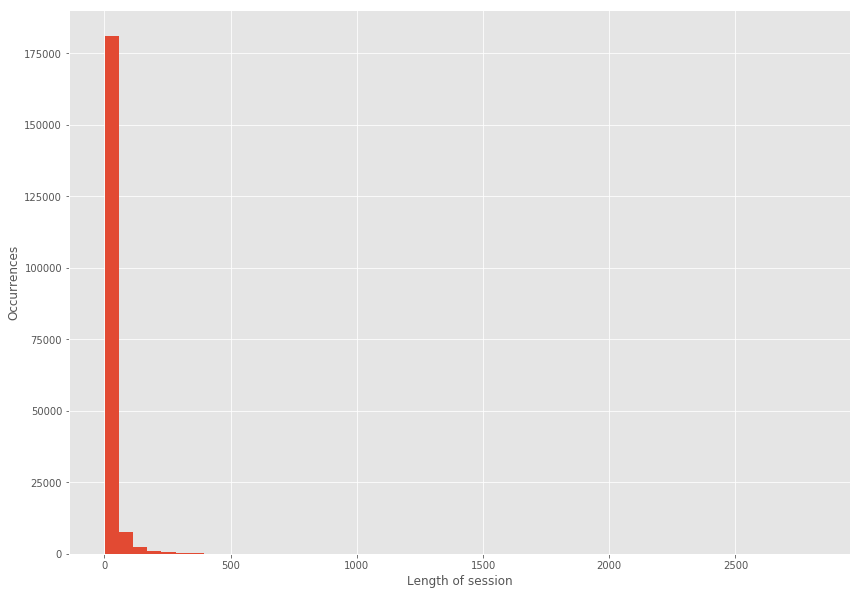

count    192971.000000
mean         16.434993
std          41.054845
min           1.000000
25%           2.000000
50%           4.000000
75%          14.000000
max        2814.000000
Name: session_len, dtype: float64


1.0       38692
2.0       27559
3.0       18186
4.0       13642
5.0       10003
6.0        7540
7.0        6169
8.0        4956
9.0        4152
10.0       3682
11.0       3155
12.0       2755
13.0       2497
14.0       2251
15.0       2108
16.0       1983
17.0       1789
18.0       1647
19.0       1546
20.0       1471
21.0       1433
22.0       1308
23.0       1240
24.0       1162
25.0       1130
26.0       1064
31.0       1022
27.0       1005
32.0        974
29.0        958
33.0        921
28.0        902
30.0        874
34.0        838
35.0        796
36.0        728
37.0        696
39.0        622
38.0        620
40.0        555
41.0        545
42.0        487
43.0        450
45.0        425
44.0        424
47.0        400
46.0        386
48.0        378
49.0        367
51.0        360
50.0        356
54.0        318
52.0        311
53.0        303
55.0        275
59.0        266
63.0        262
58.0        262
56.0        261
57.0        257
62.0        251
64.0        235
60.0    

In [11]:
plt.hist(session_len_nonna.session_len, bins=50)
plt.xlabel('Length of session')
plt.ylabel('Occurrences')
plt.show()

print(session_len_nonna.session_len.describe())
session_len_nonna.session_len.value_counts()

In [12]:
# Inspect random long session:
random_session = np.random.choice(session_len_long.index)

random_session_df = pd.concat([
    train.loc[train.session_id == random_session, :],
    test.loc[test.session_id == random_session, :],], ignore_index=False, sort=False)
print('session_id: {}, shape: {}'.format(random_session, random_session_df.shape))
random_session_df['timestamp_dt'] = random_session_df.timestamp.apply(
    lambda x: pd.datetime.fromtimestamp(x))

random_session_df

session_id: b27f6b2152dda, shape: (16, 13)


,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,is_test,timestamp_dt
18455878,N281L7W94866,b27f6b2152dda,1541689134,1,search for destination,"Thiruvananthapuram, India",IN,"Thiruvananthapuram, India",mobile,None,None,None,0,2018-11-08 15:58:54
18455879,N281L7W94866,b27f6b2152dda,1541689195,2,interaction item info,436461,IN,"Thiruvananthapuram, India",mobile,None,None,None,0,2018-11-08 15:59:55
18455880,N281L7W94866,b27f6b2152dda,1541689247,3,filter selection,Swimming Pool (Combined Filter),IN,"Thiruvananthapuram, India",mobile,Swimming Pool (Combined Filter),None,None,0,2018-11-08 16:00:47
18455881,N281L7W94866,b27f6b2152dda,1541689260,4,interaction item info,1246037,IN,"Thiruvananthapuram, India",mobile,None,None,None,0,2018-11-08 16:01:00
18455882,N281L7W94866,b27f6b2152dda,1541689300,5,search for destination,"Thiruvananthapuram, India",IN,"Thiruvananthapuram, India",mobile,None,None,None,0,2018-11-08 16:01:40
18455883,N281L7W94866,b27f6b2152dda,1541689344,6,search for destination,"Thiruvananthapuram, India",IN,"Thiruvananthapuram, India",mobile,None,None,None,0,2018-11-08 16:02:24
18455884,N281L7W94866,b27f6b2152dda,1541689365,7,clickout item,1246037,IN,"Thiruvananthapuram, India",mobile,None,436461|1246037|9313400|4642212|6536362|2227228...,31|34|38|6|28|18|34|26|49|19|9|20|25|18|26|50|...,0,2018-11-08 16:02:45
18455885,N281L7W94866,b27f6b2152dda,1541689392,8,search for destination,"Kanyakumari, India",IN,"Kanyakumari, India",mobile,None,None,None,0,2018-11-08 16:03:12
18455886,N281L7W94866,b27f6b2152dda,1541689483,9,search for destination,"Kanyakumari, India",IN,"Kanyakumari, India",mobile,None,None,None,0,2018-11-08 16:04:43
18455887,N281L7W94866,b27f6b2152dda,1541689515,10,filter selection,Swimming Pool (Combined Filter),IN,"Kanyakumari, India",mobile,Swimming Pool (Combined Filter),None,None,0,2018-11-08 16:05:15


In [13]:
df_all['timestamp_dt'] = df_all.timestamp.apply(lambda x: pd.datetime.fromtimestamp(x))
print(df_all.timestamp_dt.min(), df_all.timestamp_dt.max())

2018-11-01 01:00:08 2018-11-09 00:59:59
